# Integration with bulk RNA-seq data

A current limitation of single-cell datasets is the high cost, low sample size and often the lack of associated clinical information. On the other hand bulk RNA-seq experiments are comparatively cheap, and vast amounts of experimental data has accumulated in public repositories, including large-scale datasets with thousands of samples. This motivates integrating bulk RNA-seq data with cell-type information from single-cell RNA-seq datasets.

:::{note}
*Deconvolution methods* allow to infer cell-type proportions from bulk RNA-seq datasets based on reference signatures. Methods such as CIBERSORTx {cite}`newmanDeterminingCellType2019`, DWLS {cite}`tsoucasAccurateEstimationCelltype2019` or MuSiC {cite}`wangBulkTissueCell2019` can build such reference signatures based on single-cell RNA-seq datasets. The derived cell-type fractions can be tested for associations with clinical data. In {cite:t}`pournaraPowerAnalysisCelltype2023a`, the authors provide an overview and a comparative benchmark of such methods. 

Alternatively, *Scissor* {cite}`sunIdentifyingPhenotypeassociatedSubpopulations2022` works independent of predefined cell-populations and tests for each cell if it is positively or negatively associated with phenotypic information (e.g. survival data or driver mutations) that comes with bulk RNA-seq datasets. To do so, it calculates Pearson correlation of each cell’s gene
expression profile with the bulk RNA-seq data and uses a L1-constrained linear model to explain the phenotypic information with the correlation values.

Even though Scissor has the advantage that it works independent of known cell-types, it comes with several limitations, namely: 

 * it is computationally expensive (can run hours on a single sample)
 * it does not natively take biological replicates into account (we circumvent that by running scissor independently on each patient)
 * it does not allow to model covariates (e.g. sex, age)
:::

In {cite:t}`salcherHighresolutionSinglecellAtlas2022a`, we used Scissor to test associations of certain driver mutations with certain cell-types. In this example, we are going to demonstrate how to use Scissor for testing the effect of EGFR mutation on cell-type composition in *LUAD*. 

## 1. Import the required libraries

In [1]:
import scanpy as sc
import pandas as pd
from tqdm.contrib.concurrent import process_map
from subprocess import run
import os
import numpy as np
import atlas_protocol_scripts as aps
import altair as alt

/data/scratch/sturm/conda/envs/2023-atlas-protocol/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load input data

1. Load the annotated AnnData object

In [2]:
adata_path = "../../data/input_data_zenodo/atlas-integrated-annotated.h5ad"
adata = sc.read_h5ad(adata_path)


2. Define the paths to the bulk data. 
   * The bulk data must be a `rds` file containing a matrix samples in column names and gene symbols in row names containing untransformed TPM values.  
   * The metadata must be a TSV file where one column contains the sample identifiers used as rownames of the TPM matrix. 

In [3]:
tcga_tpm_matrix_path = "../../data/input_data_zenodo/nsclc_primary_tumor.rds"
tcga_metadata_path = "../../data/input_data_zenodo/clinical_data_for_scissor.tsv"

3. Define the paths to the scripts for Scissor and h5ad conversion. These scripts are shipped as part of the `atlas_protocol` repo. 

In [4]:
scissor_script_path = "../../bin/scissor_single_sample.R"
h5ad_to_sce_script_path = "../../bin/h5ad_to_sce.py"

4. Create output directories

In [5]:
out_dir = "../../results/scissor"
!mkdir -p {out_dir}/{{sce,h5ad,scissor_res}}

## 3. Export single-cell data for R

The scissor script requires single-cell data to be stored as a `rds` file containing a `SingleCellExperiment` object with raw counts. 

1. Subset the anndata object to the samples of interest. Since we compare to the TCGA primary tumor samples, we exclude normal samples from the single-cell dataset as well. 

In [6]:
adata_tumor = adata[adata.obs["origin"] == "tumor_primary", :].copy()

2. Define the list of biological replicates. Scissor will be run on each sample individually. 

In [7]:
patients = adata_tumor.obs["patient"].unique()

3. For each patient, store the single-cell data as `h5ad` object. 

In [8]:
for patient in patients:
    tmp_adata = adata_tumor[adata_tumor.obs["patient"] == patient, :].copy()
    tmp_adata.write_h5ad(f"{out_dir}/h5ad/{patient}.h5ad")

4. Convert `h5ad` files to `rds` files using the `h5ad_to_sce.py` script. We use `process_map` to perform the conversion in parallel. 

In [9]:
def _convert_to_sce(patient):
    run(
        [
            h5ad_to_sce_script_path,
            f"{out_dir}/h5ad/{patient}.h5ad",
            f"{out_dir}/sce/{patient}.rds",
        ],
        check=True,
    )


_ = process_map(_convert_to_sce, patients)

100%|██████████| 14/14 [00:53<00:00,  3.79s/it]


## 4. Run Scissor

:::{note}
We created a command-line script that automatically runs scissor on a single sample. In summary, it performs the following steps: 
 * filter the metadata as specified
 * preprocess the single-cell using Seurat
 * perform binomial or CoxPH regression, respectively
 * perform a grid search on the [`alpha` parameter](https://sunduanchen.github.io/Scissor/vignettes/Scissor_Tutorial.html#tune-model-paramters)

A step-by-step tutorial demonstrating how to run Scissor manually while explaining all the individual steps is available from [the package website](https://sunduanchen.github.io/Scissor/vignettes/Scissor_Tutorial.html).
:::

1. Inspect the help page of the scissor script

In [10]:
!{scissor_script_path} --help

Warning message:
package ‘conflicted’ was built under R version 4.2.2 
Warning message:
package ‘docopt’ was built under R version 4.2.1 
scissor_single_sample.R

Usage:
    scissor_single_sample.R --bulk_tpm=<bulk_tpm> --sce=<sce> --metadata=<metadata> [options]

Mandatory options:
    --bulk_tpm=<bulk_tpm>       Bulk gene expression as matrix with TPM values (not log transformed!) in rds format
    --sce=<sce>                 SingleCellExperiment in rds format. Must contain raw UMI counts in `X`.
    --metadata=<metadata>       Samplesheet with metadata in TSV format. Binary variables need to be encoded as 0 and 1. Non 0/1 values will be discarded.

The program will take the intersection of the <sample_col> in <metadata> and the colnames of <bulk_tpm>.

Optional options:
    --column=<column>               Column with binary variable for binomial regression
    --filter_col=<filter_col>       Column by which to filter the samples
    --filter_val=<filter_val>       Only keep rows in 

2. Run the scissor script on each `rds` file generated above

In [ ]:
def _run_scissor(patient):
    tmp_out_dir = f"{out_dir}/scissor_res/{patient}"
    os.makedirs(tmp_out_dir, exist_ok=True)
    # fmt: off
    res = run(
        [
            scissor_script_path,
            "--bulk_tpm", tcga_tpm_matrix_path,
            "--sce", f"{out_dir}/sce/{patient}.rds",
            "--metadata", tcga_metadata_path,
            "--column", "egfr_mutation", 
            "--filter_col", "type", "--filter_val", "LUAD",
            "--sample_col", "TCGA_patient_barcode",
            "--out_dir", f"{out_dir}/scissor_res/{patient}",
        ],
        check=False,
        capture_output=True,
    )
    # fmt: on
    
    # Write STDERR and STDOUT to log file
    with open(f"{tmp_out_dir}/{patient}.out", "wb") as f:
        f.write(res.stdout)
    with open(f"{tmp_out_dir}/{patient}.err", "wb") as f:
        f.write(res.stderr)
    return res


scissor_log = process_map(_run_scissor, patients)

  7%|▋         | 1/14 [20:21<4:24:40, 1221.54s/it]

3. Check if scissor could be executed successfully on all samples

:::{warning}
The scissor script may fail on some samples. We can ignore these samples and proceed with the downstream analysis.

The most common reason is that a single sample has too few cells for the automatic Seurat preprocessing to complete successfully. 
We recommend inspecting the log files written to the output directory for each failed sample. 
:::

In [11]:
for patient, log in zip(patients, scissor_log):
    if log.returncode != 0:
        print(f"patient '{patient}' failed!")

NameError: name 'scissor_log' is not defined

## 5. Load scissor results

For each sample, scissor generates a tsv file with a label for each cell. The label can be either "scissor+" (i.e. the cell is positively associated with the phenotype of interest), "scissor-" (i.e. negatively associated), or "NA" (i.e. not associated). 

1. read the `tsv` files generated by the scissor script

In [16]:
scissor_res = {}
for patient in patients:
    try:
        scissor_res[patient] = pd.read_csv(
            f"{out_dir}/scissor_res/{patient}/scissor_egfr_mutation_LUAD.tsv",
            sep="\t",
            index_col="cell_id",
        )
    except IOError:
        print(f"no result found for '{patient}'!")
        pass

no result found for 'Maynard_Bivona_2020_TH158'!
no result found for 'Maynard_Bivona_2020_TH169'!


2. Assign the results back to the AnnData object. 

In [17]:
adata_tumor.obs["scissor_egfr"] = pd.concat(scissor_res.values())

3. Assign cells that are neither "scissor+" nor "scissor-" cells the label "neutral"

In [18]:
adata_tumor.obs["scissor_egfr"].fillna("neutral", inplace=True)

## 6. Visualize on UMAP

/data/scratch/sturm/conda/envs/2023-atlas-protocol/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


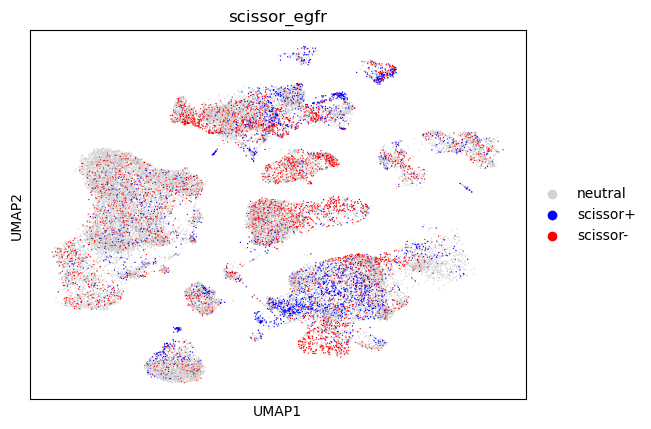

In [19]:
sc.pl.umap(
    adata_tumor,
    color="scissor_egfr",
    palette={"scissor+": "blue", "scissor-": "red", "neutral": "lightgrey"},
)

## 7. Statistical comparison

1. For each patient and cell-type, compute the fraction of "scissor+", "scissor-" and "neutral" cells

In [ ]:
scissor_fractions = (
    # make data frame of scissor+/scissor-/neutral counts for each patient and cell-type
    adata_tumor.obs.groupby(["cell_type", "patient", "scissor_egfr"])
    .size()
    .unstack()
    # keep only samples with > 10 cells
    .loc[lambda x: x.apply(lambda row: np.sum(row), axis=1) > 10]
    # normalize to fractions per sample
    .apply(lambda row: row / np.sum(row), axis=1)
)
scissor_fractions

2. For each cell-type, perform a wilcoxon test to compare the fractions of "scissor+" and "scissor-" cells and compute the log2 ratio of fractions 

In [ ]:
scissor_test_results = (
    scissor_fractions.groupby("cell_type")
    .apply(aps.tl.scissor_wilcoxon_test)
    .pipe(aps.tl.fdr_correction)
    .reset_index()
)
scissor_test_results.head()

3. Filter the results to keep only cell-types with an FDR smaller than a specified threshold

In [20]:
scissor_test_results_filtered = scissor_test_results.loc[lambda x: x["fdr"] < 0.1]

NameError: name 'scissor_test_results' is not defined

## 8. Plot results as bar chart using altair

In [ ]:
order = scissor_test_results_filtered.sort_values("log2_ratio")["cell_type"].tolist()
max_ = np.max(np.abs(scissor_test_results_filtered["log2_ratio"]))
(
    alt.Chart(scissor_test_results_filtered)
    .mark_bar()
    .encode(
        x=alt.X("cell_type", sort=order, axis=alt.Axis(labelLimit=400)),
        y=alt.Y("log2_ratio", scale=alt.Scale(domain=[-5.5, 5.5])),
        color=alt.Color(
            "log2_ratio", scale=alt.Scale(scheme="redblue", domain=[-max_, max_])
        ),
    )
    .properties(height=100)
)